# Statistical Correlations
We examine independence teseting, two-sample KS and Correaltions using the  [House prices dataset (Kaggle)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) <br> 



### 0. Imports

In [69]:
#data processing
import pandas as pd
import numpy as np
import scipy as sp

#statistics
from scipy import stats
import statsmodels.api as sm


#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Machine learning library
import sklearn

import warnings
warnings.filterwarnings("ignore")


##### Loading the CSV dataset

In [70]:
dataset_path = "../datasets/houseprices/train.csv"
dtf = pd.read_csv(dataset_path,index_col='Id')

In [71]:
dtf.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


##### Defining numeric and categorical columns

In [72]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if dtf[nc].nunique()>20]
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]

##### Filling Null Values with the column's mean

In [73]:
na_columns = dtf[very_numerical].isna().sum()
na_columns = na_columns[na_columns>0]
for nc in na_columns.index:
    dtf[nc].fillna(dtf[nc].mean(),inplace=True)

##### Dropping and filling NA values for categorical columns:

1. drop if at least 70% are NA:

In [74]:
nul_cols = dtf[categorical_columns].isna().sum()/len(dtf)
drop_us = nul_cols[nul_cols>0.7]
drop_us

Alley          0.937671
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

In [75]:
dtf=dtf.drop(drop_us.index,axis=1)
categorical_columns = list(set(categorical_columns)-set(drop_us.index))

2. Fill with a new 'na' category:

In [76]:
dtf[categorical_columns].fillna('na',inplace=True)

## 1. Two-Sample KS

##### We can use KS too examine, e.g., whether the train and test come from the same distributions:

In [77]:
test_dataset_path = "../datasets/houseprices/test.csv"
dtf_test = pd.read_csv(test_dataset_path,index_col='Id')

In [78]:
#filling null values using the train:
for nc in na_columns.index:
    dtf_test[nc].fillna(dtf[nc].mean(),inplace=True)

In [79]:
from scipy.stats import ks_2samp

In [80]:
ks_2samp(dtf.GrLivArea,dtf_test.GrLivArea)

KstestResult(statistic=0.04636972217788502, pvalue=0.08165723197507636)

##### Comparing all numeric test/train columns:

In [81]:
ks_res=[]
for col in very_numerical:
    try:
        res,pval = ks_2samp(dtf[col],dtf_test[col])
        ks_res.append({'col':col,'ks_score':res,'p_val':pval})
    except:
        pass
ks_df = pd.DataFrame(ks_res)

In [82]:
ks_df.sort_values('p_val',ascending=True)[:10]

,col,ks_score,p_val
0,LotFrontage,0.185373,1.878096e-22
10,2ndFlrSF,0.047094,7.370757e-02
12,GrLivArea,0.046370,8.165723e-02
8,TotalBsmtSF,0.041186,1.628113e-01
1,LotArea,0.037240,2.559294e-01
3,YearRemodAdd,0.037196,2.576886e-01
7,BsmtUnfSF,0.029872,5.173430e-01
17,EnclosedPorch,0.029570,5.343483e-01
5,BsmtFinSF1,0.027048,6.447772e-01
13,GarageYrBlt,0.024837,7.459942e-01


We can see one column that is slightly different. Let's examine:

<AxesSubplot:xlabel='LotFrontage'>

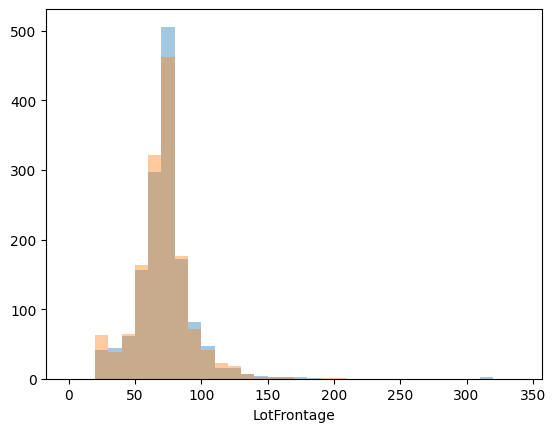

In [15]:
fig,ax = plt.subplots()
sns.distplot(dtf.LotFrontage,ax=ax,bins=range(0,350,10),kde=False)
sns.distplot(dtf_test.LotFrontage,ax=ax,bins=range(0,350,10),kde=False)


Can't see major differences, trying a Box plot:

Text(0.5, 1.0, 'Test')

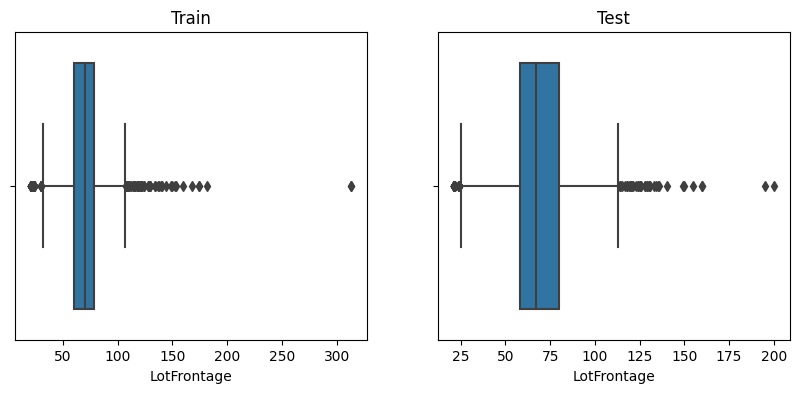

In [39]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
sns.boxplot(dtf.LotFrontage,ax=axes[0]).set_title('Train')
sns.boxplot(dtf_test.LotFrontage,ax=axes[1]).set_title('Test')

To make sure, let's comapre their statistics using `pd.Series.describe()`

In [40]:
describe_df=pd.DataFrame([dtf.LotFrontage.describe(),dtf_test.LotFrontage.describe()]).T
describe_df.columns=['Train','Test']
describe_df

,Train,Test
count,1460.000000,1232.000000
mean,70.049958,68.580357
std,22.024023,22.376841
min,21.000000,21.000000
25%,60.000000,58.000000
50%,70.049958,67.000000
75%,79.000000,80.000000
max,313.000000,200.000000


#### How to test this for categorical columns? Chi-square test (one-way)

In [92]:
frequencies = dtf.LotShape.value_counts()/dtf.LotShape.value_counts().sum()

In [87]:
from scipy.stats import chisquare

In [104]:
for c in categorical_columns:
    train_freqs = dtf[c].value_counts()/dtf[c].value_counts().sum()
    test_freqs = dtf_test[c].value_counts()/dtf_test[c].value_counts().sum()
    if len(train_freqs)!=len(test_freqs):
        trf = set(train_freqs.keys())
        tsf = set(test_freqs.keys())
        add_to_train = tsf - trf
        for t in add_to_train:
            train_freqs[t]=0.0
        add_to_test = trf - tsf
        for t in add_to_test:
            test_freqs[t]=0.0
        #print(train_freqs,test_freqs)
        
        
    print(c,": ",chisquare(test_freqs,f_exp=train_freqs))

SaleType :  Power_divergenceResult(statistic=0.006799764523987479, pvalue=0.9999999999944478)
Foundation :  Power_divergenceResult(statistic=0.0034528013413567594, pvalue=0.9999999627829228)
MasVnrType :  Power_divergenceResult(statistic=0.001738046757152941, pvalue=0.9999807387461781)
Street :  Power_divergenceResult(statistic=1.938546665891123e-09, pvalue=0.9999648699966358)
SaleCondition :  Power_divergenceResult(statistic=0.005113240208507345, pvalue=0.9999999007349729)
BldgType :  Power_divergenceResult(statistic=0.002056832952780717, pvalue=0.9999994715422007)
GarageFinish :  Power_divergenceResult(statistic=0.0028040647175433713, pvalue=0.9985989500294289)
Condition2 :  Power_divergenceResult(statistic=0.0028577996017046096, pvalue=0.9999999999905294)
RoofMatl :  Power_divergenceResult(statistic=0.0054880092397952725, pvalue=0.9999999999071513)
Neighborhood :  Power_divergenceResult(statistic=0.023434622835060443, pvalue=1.0)
ExterCond :  Power_divergenceResult(statistic=0.01247

In [95]:
chisquare(dtf_test.LotShape.value_counts()/dtf_test.LotShape.value_counts().sum(),f_exp=dtf.LotShape.value_counts()/dtf.LotShape.value_counts().sum())

Power_divergenceResult(statistic=0.0017592113934219561, pvalue=0.9999803859780442)

## 2. Independence Testing


##### To run a chi-square test of indepedence we need to first create a contingency table and only then run the test:

In [84]:
contingency_table = pd.crosstab(dtf.LotShape,dtf.SaleCondition)
contingency_table

SaleCondition,Abnorml,AdjLand,Alloca,Family,Normal,Partial
LotShape,,,,,,
IR1,31,1,2,4,398,48
IR2,2,0,0,0,35,4
IR3,0,0,0,1,7,2
Reg,68,3,10,15,758,71


In [85]:
c, p, dof, expected = stats.chi2_contingency(contingency_table)
c,p

(15.026444980007037, 0.44951400522655577)

The p-value shows that the null-hypothesis of independence cannot be rejected,
therefore the two column are probably *independent*. We can examine the expected table:

In [86]:
pd.DataFrame(expected,columns=contingency_table.columns,index=contingency_table.index)

SaleCondition,Abnorml,AdjLand,Alloca,Family,Normal,Partial
LotShape,,,,,,
IR1,33.482192,1.326027,3.978082,6.630137,397.145205,41.438356
IR2,2.836301,0.112329,0.336986,0.561644,33.642466,3.510274
IR3,0.691781,0.027397,0.082192,0.136986,8.205479,0.856164
Reg,63.989726,2.534247,7.602740,12.671233,759.006849,79.195205


##### Performing the chi-square test over all columns:

In [22]:
chi_res=[]
for i1,c1 in enumerate(categorical_columns):
    for i2,c2 in enumerate(categorical_columns):
        try:
            contingency_table = pd.crosstab(dtf[c1],dtf[c2])
            c, p,_,_ = stats.chi2_contingency(contingency_table)
        except:
            c=None
            p=None
        chi_res.append({'col1':c1,'col2':c2,'score':c,'p_val':p})


In [52]:
chi_df= pd.DataFrame(chi_res)
chi_df.head()

,col1,col2,score,p_val
0,SaleType,SaleType,11680.000000,0.000000e+00
1,SaleType,Foundation,202.843211,1.184273e-23
2,SaleType,MasVnrType,179.282292,1.004333e-25
3,SaleType,Street,25.945029,1.073291e-03
4,SaleType,SaleCondition,1652.675077,0.000000e+00


Examining the column-pairs with high P value (meaning, the columns may be dependent)

In [57]:
chi_df[chi_df.p_val>0.3].sort_values('p_val',ascending=False)

,col1,col2,score,p_val
307,Condition2,Functional,1.114390,1.000000
281,Condition2,RoofMatl,0.274790,1.000000
447,Utilities,CentralAir,0.000000,1.000000
319,RoofMatl,Condition2,0.274790,1.000000
301,Condition2,Heating,0.339624,1.000000
...,...,...,...,...
629,BsmtFinType2,BldgType,22.535274,0.312185
224,BldgType,GarageCond,18.271186,0.308258
1136,GarageCond,BldgType,18.271186,0.308258
631,BsmtFinType2,Condition2,38.703008,0.306079


In [53]:
col1 = 'Heating'
col2 = 'Condition2'

In [54]:
contingency_table = pd.crosstab(dtf[col1],dtf[col2])
contingency_table

Condition2,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNn
Heating,,,,,,,,
Floor,0,0,1,0,0,0,0,0
GasA,2,6,1413,1,2,1,1,2
GasW,0,0,18,0,0,0,0,0
Grav,0,0,7,0,0,0,0,0
OthW,0,0,2,0,0,0,0,0
Wall,0,0,4,0,0,0,0,0


In [27]:
dtf.Heating.value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

#### Examining Correlations to the target feature:

Starting with Pearson:

In [ ]:
dtf.corr(

<AxesSubplot:>

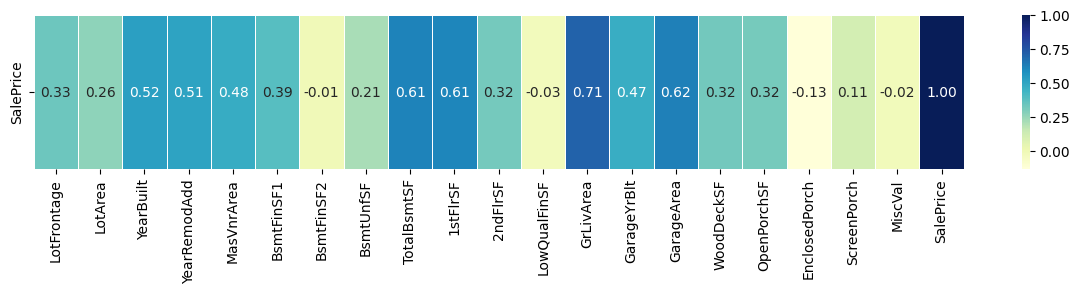

In [28]:
dtf_corr = dtf[very_numerical].corr(method="pearson").loc[["SalePrice"]]
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)


Also trying Spearman

<AxesSubplot:>

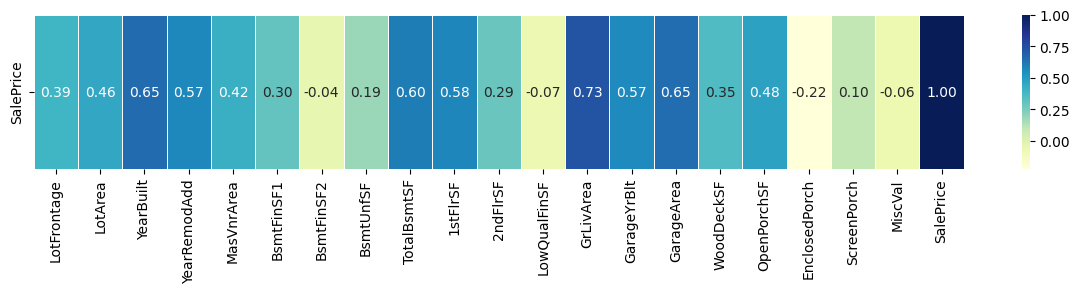

In [58]:
dtf_corr = dtf[very_numerical].corr(method="spearman").loc[["SalePrice"]]
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)


Spearman should work better for ordinal features (e.g., rankings) 

In [59]:
ordinals = list(set(numeric_columns) - set(very_numerical))

In [60]:
ordinals.append('SalePrice')

<AxesSubplot:>

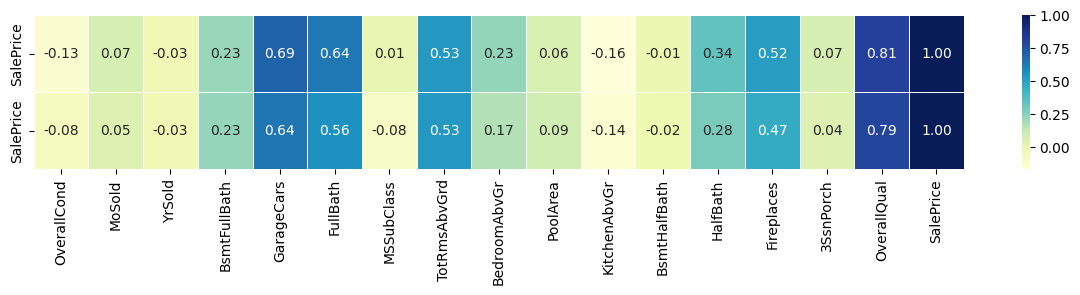

In [61]:
dtf_corr = dtf[ordinals].corr(method="spearman").loc[["SalePrice"]]
dtf_corr = dtf_corr.append(dtf[ordinals].corr(method="pearson").loc[["SalePrice"]])
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)


As SalePrice is numeric, we can bin it to become ordinal:

In [62]:
binned_price = pd.cut(dtf.SalePrice,10)
#binned_price = pd.qcut(dtf.SalePrice,10) #we could use equi-height binning as well
binned_price.head()

Id
1    (178920.0, 250930.0]
2    (178920.0, 250930.0]
3    (178920.0, 250930.0]
4    (106910.0, 178920.0]
5    (178920.0, 250930.0]
Name: SalePrice, dtype: category
Categories (10, interval[float64, right]): [(34179.9, 106910.0] < (106910.0, 178920.0] < (178920.0, 250930.0] < (250930.0, 322940.0] ... (466960.0, 538970.0] < (538970.0, 610980.0] < (610980.0, 682990.0] < (682990.0, 755000.0]]

In [63]:
binned_price = binned_price.cat.codes

In [64]:
dtf_ordinal=dtf[ordinals]
dtf_ordinal["SalePrice"]=binned_price

See whether the correlation changed:

<AxesSubplot:>

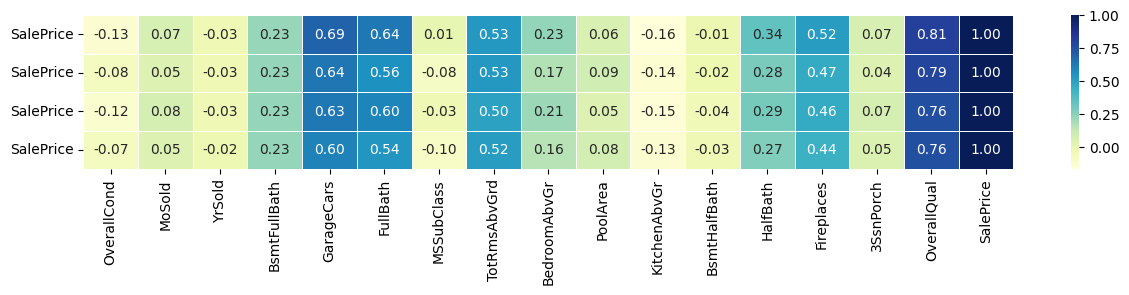

In [65]:
#dtf_corr = dtf_ordinal.corr(method="spearman").loc[["SalePrice"]]
dtf_corr = dtf_corr.append(dtf_ordinal.corr(method="spearman").loc[["SalePrice"]])
dtf_corr= dtf_corr.append(dtf_ordinal.corr(method="pearson").loc[["SalePrice"]])
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)


##### Last, let's examine cross-feature correlations:

In [66]:
dtf_corr = dtf[ordinals].corr(method="spearman")

<AxesSubplot:>

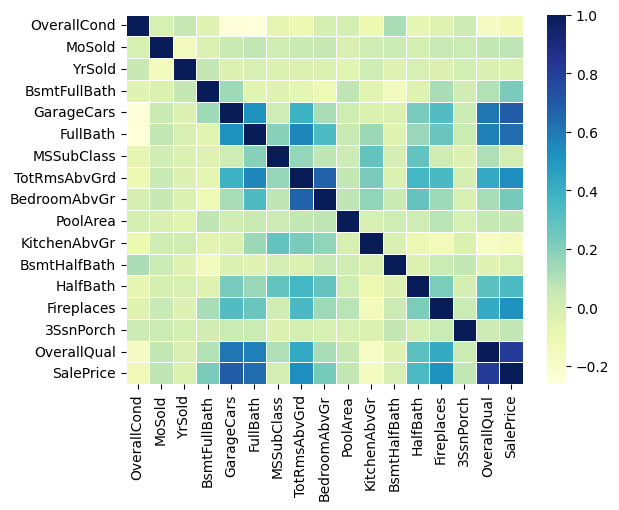

In [67]:
dtf_corr
sns.heatmap(dtf_corr, annot=False, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
